#**Thompson sampling** for solving Multi-Arm Bandit


It is an algorithm that uses ​​exploration and exploitation to choose the actions that would maximize the rewards earned. It is also known as Probability Matching or Posterior Sampling.
In Thompson sampling, as more information is gathered, the search is decreased which leads to get us the result in fewest searches as possible.
The algorithm is inversely dependent on the size of the data i.e the algorithm is more search-oriented when there is less data available, and less search-oriented when there is more data at our disposal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ThompsonSampling:

  def __init__(self, n_arms, reward_funcs):
    self.n_arms = n_arms
    self.reward_funcs = reward_funcs
    self.alpha = np.ones(n_arms)
    self.beta = np.ones(n_arms)
    self.rewards = []
    self.counts = np.zeros(n_arms)


  def initialize(self):
        for arm in range(self.n_arms):
            reward = self.reward_funcs[arm]()
            self.update(arm, reward)
            self.rewards.append(reward)

  def select_arm(self):
      samples = [np.random.beta(max(1, self.alpha[i]), max(1, self.beta[i])) for i in range(self.n_arms)]
      return np.argmax(samples)

  def update(self, arm, reward):
      self.counts[arm] += 1
      n = self.counts[arm]
      self.alpha[arm] = (self.alpha[arm] * (n - 1) + max(0, reward)) / n
      self.beta[arm] = (self.beta[arm] * (n - 1) + max(0, 1 - reward)) / n
      self.rewards.append(reward)

In [3]:
def create_custom_arm(n_arms, reward_funcs):
    """
    Create arms with custom reward functions.

    :param n_arms: Number of arms
    :param reward_funcs: List of custom reward functions
    :return: List of reward functions
    """
    assert len(reward_funcs) == n_arms, "Number of reward functions must match the number of arms"
    return reward_funcs

##Reward Functions

In [4]:
def bernoulli_reward(p):
    return lambda: np.random.binomial(1, p)

def normal_reward(mean, std):
    return lambda: np.random.normal(mean, std)

def exponential_reward(scale):
    return lambda: np.random.exponential(scale)

In [5]:
def run(n_arms, n_iters, n_experiments, custom_reward_funcs=None):
  cumulative_rewards = np.zeros((n_experiments, n_iters))
  optimal_arm_selections = np.zeros((n_experiments, n_iters))

  for experiment in range(n_experiments):
      if custom_reward_funcs:
          reward_funcs = create_custom_arm(n_arms, custom_reward_funcs)
      else:
          reward_funcs = [normal_reward(np.random.uniform(0, 1), 1) for _ in range(n_arms)]

      true_means = [np.mean([func() for _ in range(1000)]) for func in reward_funcs]
      optimal_arm = np.argmax(true_means)

      agent = ThompsonSampling(n_arms, reward_funcs)
      agent.initialize()

      for it in range(n_iters):
          selected_arm = agent.select_arm()
          reward = reward_funcs[selected_arm]()
          agent.update(selected_arm, reward)
          cumulative_rewards[experiment, it] = reward
          optimal_arm_selections[experiment, it] = int(selected_arm == optimal_arm)

  return cumulative_rewards, optimal_arm_selections


##plot

In [6]:
def plot_results(cumulative_rewards, optimal_arm_selections, n_iterations):
  plt.figure(figsize = (12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(np.cumsum(np.mean(cumulative_rewards, axis = 0)))
  plt.title('Cumulative Reward')
  plt.xlabel('Iterations')
  plt.ylabel('Cumulative Reward')

  plt.subplot(1, 2, 2)
  plt.plot(np.cumsum(np.mean(optimal_arm_selections, axis = 0)) / np.arange(1, n_iterations + 1))
  plt.title('Optimal Arm Selection Rate')
  plt.xlabel('Iterations')
  plt.ylabel('Optimal Arm Selection Rate')

  plt.tight_layout()
  plt.show()

In [7]:
custom_rewards = [
    bernoulli_reward(0.7),
    normal_reward(2, 1),
    exponential_reward(1.5),
    lambda: np.random.choice([0, 1, 2, 3], p=[0.4, 0.3, 0.2, 0.1]),
    lambda: max(0, np.random.normal(5, 2))  # Truncated normal
]

In [8]:
n_arms = 5
n_iterations = 1000
n_experiments = 100

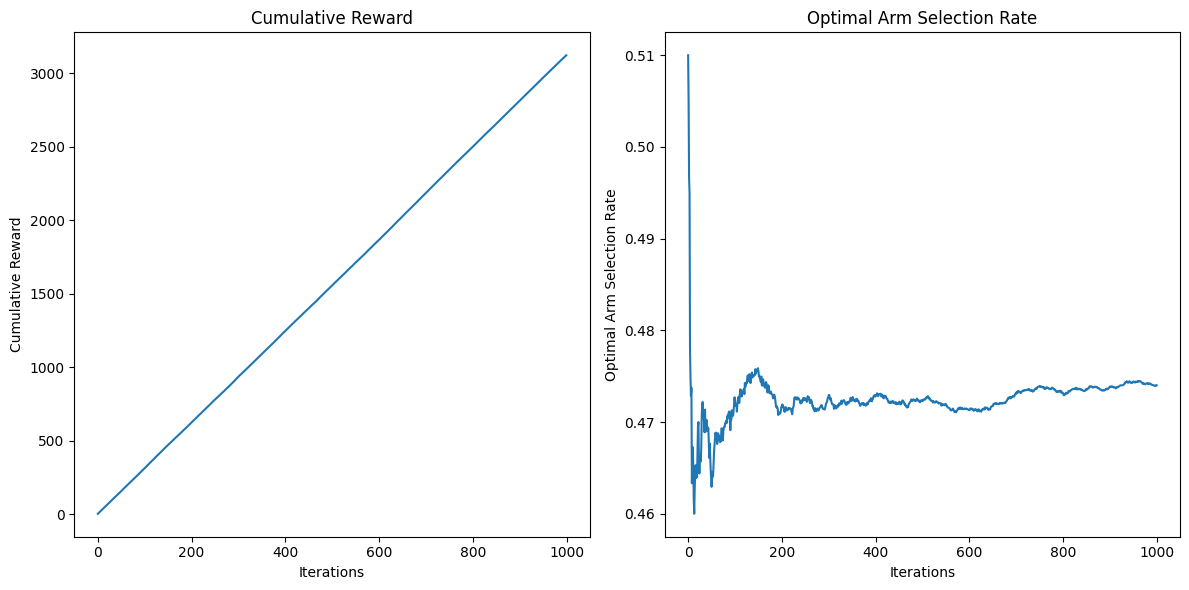

In [9]:
cumulative_rewards, optimal_arm_selections = run(n_arms, n_iterations, n_experiments, custom_rewards)
plot_results(cumulative_rewards, optimal_arm_selections, n_iterations)